In [25]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()

# Get the uploaded file name dynamically
file_name = list(uploaded.keys())[0]



Saving ADANIPORTS.NS.csv to ADANIPORTS.NS (4).csv


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Episode 1/50, Total Reward: nan, Net Worth: nan
Episode 2/50, Total Reward: nan, Net Worth: nan
Episode 3/50, Total Reward: nan, Net Worth: nan


<ipython-input-26-d61f36fef3b8>:60: RuntimeWarning: divide by zero encountered in scalar floor_divide
  shares_to_buy = self.balance // current_price
<ipython-input-26-d61f36fef3b8>:61: RuntimeWarning: invalid value encountered in scalar multiply
  self.balance -= shares_to_buy * current_price
<ipython-input-26-d61f36fef3b8>:67: RuntimeWarning: invalid value encountered in scalar multiply
  self.net_worth = self.balance + self.shares_held * current_price


Episode 4/50, Total Reward: nan, Net Worth: nan
Episode 5/50, Total Reward: nan, Net Worth: nan
Episode 6/50, Total Reward: nan, Net Worth: nan
Episode 7/50, Total Reward: nan, Net Worth: nan
Episode 8/50, Total Reward: nan, Net Worth: nan
Episode 9/50, Total Reward: nan, Net Worth: nan
Episode 10/50, Total Reward: nan, Net Worth: nan
Episode 11/50, Total Reward: nan, Net Worth: nan
Episode 12/50, Total Reward: nan, Net Worth: nan
Episode 13/50, Total Reward: nan, Net Worth: nan
Episode 14/50, Total Reward: nan, Net Worth: nan
Episode 15/50, Total Reward: nan, Net Worth: nan
Episode 16/50, Total Reward: nan, Net Worth: nan
Episode 17/50, Total Reward: nan, Net Worth: nan
Episode 18/50, Total Reward: nan, Net Worth: nan
Episode 19/50, Total Reward: nan, Net Worth: nan
Episode 20/50, Total Reward: nan, Net Worth: nan
Episode 21/50, Total Reward: nan, Net Worth: nan
Episode 22/50, Total Reward: nan, Net Worth: nan
Episode 23/50, Total Reward: nan, Net Worth: nan
Episode 24/50, Total Rewar

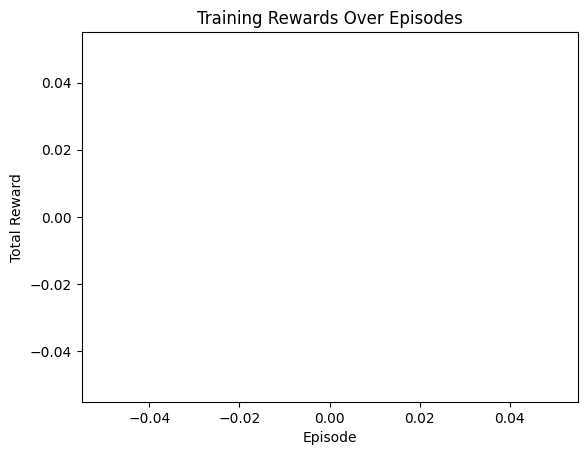

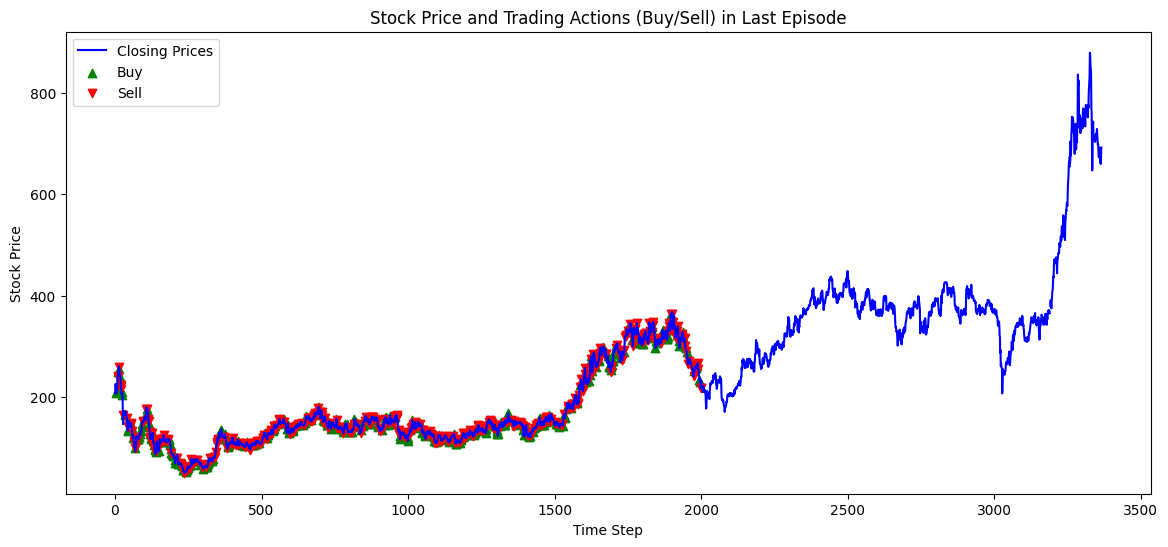

In [26]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import matplotlib.pyplot as plt

# Set up display for plots
%matplotlib inline

# Constants
WINDOW_SIZE = 10    # Number of past days used for prediction
EPISODES = 50       # Number of training episodes
BATCH_SIZE = 32     # Batch size for training
GAMMA = 0.95        # Discount factor for reward
EPSILON = 1.0       # Exploration rate
EPSILON_DECAY = 0.995  # Decay rate for exploration
EPSILON_MIN = 0.01     # Minimum exploration rate
LEARNING_RATE = 0.001  # Learning rate for the optimizer

# Load and Preprocess the Data
data = pd.read_csv(file_name)  # Adjusted to the correct file name

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
price_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data
scaler = MinMaxScaler()
price_data = scaler.fit_transform(price_data)

# Stock Trading Environment
class StockTradingEnv:
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.reset()

    def reset(self):
        self.current_step = self.window_size
        self.balance = 1000  # Initial balance
        self.shares_held = 0
        self.net_worth = self.balance
        self.done = False
        self.history = deque(maxlen=self.window_size)

        for i in range(self.window_size):
            self.history.append(self.data[i])
        return np.array(self.history)

    def step(self, action):
        # Action 0: Hold, 1: Buy, 2: Sell
        current_price = self.data[self.current_step][3]  # Close price

        if action == 1:  # Buy
            shares_to_buy = self.balance // current_price
            self.balance -= shares_to_buy * current_price
            self.shares_held += shares_to_buy
        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            self.shares_held = 0

        self.net_worth = self.balance + self.shares_held * current_price
        reward = self.net_worth - self.balance  # Reward as profit
        self.current_step += 1
        self.done = self.current_step >= len(self.data) - 1
        self.history.append(self.data[self.current_step])

        return np.array(self.history), reward, self.done

# DQN Agent
class DQNAgent:
    def __init__(self):
        self.memory = deque(maxlen=2000)
        self.epsilon = EPSILON
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            LSTM(64, input_shape=(WINDOW_SIZE, 5), return_sequences=True),
            Dropout(0.2),
            LSTM(32),
            Dense(24, activation='relu'),
            Dense(3, activation='linear')  # Output layer for 3 actions
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(3)  # Explore: select a random action
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Exploit: select the best action

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += GAMMA * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY

# Initialize environment and agent
env = StockTradingEnv(price_data, WINDOW_SIZE)
agent = DQNAgent()

# Training Loop
rewards = []
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, WINDOW_SIZE, 5])
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, WINDOW_SIZE, 5])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            rewards.append(total_reward)
            print(f"Episode {e+1}/{EPISODES}, Total Reward: {total_reward:.2f}, Net Worth: {env.net_worth:.2f}")
            break

    agent.train()

# Plot the rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards Over Episodes')
plt.show()

# Additional Visualizations
price_data_rescaled = scaler.inverse_transform(price_data)
closing_prices = price_data_rescaled[env.window_size:, 3]

# Plot Buy/Sell actions in the last episode
plt.figure(figsize=(14, 6))
buy_points = [i for i, (_, action, _, _, _) in enumerate(agent.memory) if action == 1]
sell_points = [i for i, (_, action, _, _, _) in enumerate(agent.memory) if action == 2]

plt.plot(closing_prices, label='Closing Prices', color='blue')
plt.scatter(buy_points, [closing_prices[i] for i in buy_points], marker='^', color='green', label='Buy')
plt.scatter(sell_points, [closing_prices[i] for i in sell_points], marker='v', color='red', label='Sell')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title('Stock Price and Trading Actions (Buy/Sell) in Last Episode')
plt.legend()
plt.show()
